In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!pip install lightgbm

  Using cached catboost-1.1.1-cp39-none-manylinux1_x86_64.whl (76.6 MB)
     |████████████████████████████████| 11.6 MB 2.7 MB/s            
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
     |████████████████████████████████| 17.3 MB 73 kB/s             
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
     |████████████████████████████████| 15.2 MB 145 kB/s            
     |████████████████████████████████| 34.5 MB 22 kB/s             
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 1.0 MB 2.8 MB/s            
  Using cached contourpy-1.0.7-cp39-cp39-manylinux_2_17_x86_64.manylinu

In [1]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import r2_score, mean_squared_error

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

from tqdm import tqdm
np.random.seed(42)


# Data Prep & EDA

## Загрузка и предобработка данных

In [2]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
files = [f'{i}_advanced_plus_totals.csv' for i in range(2011, 2022)]
for idx, file in enumerate(files):
    if idx == 0:
        df = pd.read_csv(f'data/{file}')
        df['year'] = int(file[:4])
    else:
        df_loc = pd.read_csv(f'data/{file}')
        df_loc['year'] = int(file[:4])
        df = pd.concat([df, df_loc])
df = df.drop(['Salary'], axis=1)
df.sample(10)

Player Pos  Age   Tm   G  GS    MP   FG  FGA    FG%  ...  STL%  \
79       Baron Davis  PG   32  NYK  29  14   595   68  184  0.370  ...   2.9   
38      DeJuan Blair  PF   25  WAS  29   0   180   26   57  0.456  ...   2.0   
2       Cole Aldrich   C   24  TOT  45   0   388   44   80  0.550  ...   0.7   
316    Yuta Watanabe  SF   24  MEM  15   0   174   15   51  0.294  ...   1.1   
257    Dirk Nowitzki  PF   38  DAL  54  54  1424  296  678  0.437  ...   1.1   
286  Thomas Robinson  PF   22  POR  70   0   873  141  293  0.481  ...   1.3   
28    Jerryd Bayless  PG   26  MIL  77   4  1717  220  516  0.426  ...   1.8   
97     Toney Douglas  SG   28  NOP  12   0   177   19   51  0.373  ...   3.3   
73   Jordan Crawford  SG   23  WAS  64  32  1753  349  872  0.400  ...   1.7   
240    Quincy Miller  PF   22  TOT  10   0   119    9   38  0.237  ...   3.0   

     TOV%  TRB%    TS%  USG%  VORP   WS  WS/48   SalaryAdj  year  
79   28.1   5.4  0.457  20.4   0.0  0.2  0.014  19174902.0  2012  
38   17.9  17.5  0.469  18.3  -0.3  0.1  0.033   2483351.0  2015  
2    20.6  17.7  0.563  12.7  -0.1  0.6  0.070   1122146.0  2013  
316   9.8  10.0  0.352  15.8  -0.3 -0.2 -0.065     92045.0  2019  
257   6.6  14.4  0.529  25.8   1.0  2.5  0.084   6048274.0  2017  
286  14.5  18.9  0.502  19.7  -0.3  1.6  0.090   4572982.0  2014  
28   18.8   7.0  0.519  18.6   0.0  2.4  0.066   3725027.0  2015  
97   15.0   7.1  0.450  17.2   0.0  0.2  0.046   3689723.0  2015  
73   12.8   5.4  0.488  28.1   0.1  1.1  0.029   1547782.0  2012  
240  10.5   9.4  0.338  17.8  -0.1 -0.1 -0.030     62083.0  2015  

[10 rows x 51 columns]

In [3]:
df.shape

(3976, 51)

In [4]:
df.describe()

Age            G           GS           MP           FG  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000   
mean     25.980634    54.824698    27.824447  1304.657193   210.537475   
std       4.080125    22.091945    28.442512   804.503983   165.912698   
min      19.000000     1.000000     0.000000     0.000000     0.000000   
25%      23.000000    40.000000     2.000000   602.750000    74.000000   
50%      25.000000    61.000000    16.000000  1295.000000   181.000000   
75%      29.000000    73.000000    55.000000  1962.250000   307.000000   
max      42.000000    83.000000    82.000000  3227.000000   857.000000   

               FGA          FG%           3P          3PA          3P%  ...  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000  ...   
mean    459.633551     0.449906    48.782696   135.915996     0.277080  ...   
std     353.425880     0.085074    54.606877   142.808977     0.155784  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     169.000000     0.409000     3.000000    11.000000     0.220750  ...   
50%     392.000000     0.444000    31.000000    96.000000     0.331000  ...   
75%     671.000000     0.487000    79.000000   220.250000     0.374000  ...   
max    1941.000000     1.000000   402.000000  1028.000000     1.000000  ...   

              STL%         TOV%         TRB%          TS%         USG%  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000   
mean      1.582721    13.073969    10.131916     0.533724    18.864336   
std       0.801515     5.158837     4.759968     0.077721     5.303849   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.100000    10.100000     6.300000     0.502000    15.100000   
50%       1.500000    12.500000     9.100000     0.539000    18.200000   
75%       1.900000    15.300000    13.100000     0.574000    22.100000   
max      16.200000   100.000000    55.900000     1.000000    43.900000   

              VORP           WS        WS/48     SalaryAdj         year  
count  3976.000000  3976.000000  3976.000000  3.976000e+03  3976.000000  
mean      0.708350     2.823516     0.086314  7.943507e+06  2016.144869  
std       1.332865     2.848407     0.072712  8.831567e+06     3.177300  
min      -2.000000    -2.100000    -0.899000  2.092400e+04  2011.000000  
25%      -0.100000     0.600000     0.050000  1.830929e+06  2013.000000  
50%       0.300000     2.100000     0.089000  4.294796e+06  2016.000000  
75%       1.100000     4.200000     0.126000  1.088712e+07  2019.000000  
max       9.900000    19.300000     0.475000  4.992861e+07  2021.000000  

[8 rows x 48 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3976 entries, 0 to 411
Data columns (total 51 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     3976 non-null   object 
 1   Pos        3976 non-null   object 
 2   Age        3976 non-null   int64  
 3   Tm         3976 non-null   object 
 4   G          3976 non-null   int64  
 5   GS         3976 non-null   int64  
 6   MP         3976 non-null   int64  
 7   FG         3976 non-null   int64  
 8   FGA        3976 non-null   int64  
 9   FG%        3976 non-null   float64
 10  3P         3976 non-null   int64  
 11  3PA        3976 non-null   int64  
 12  3P%        3976 non-null   float64
 13  2P         3976 non-null   int64  
 14  2PA        3976 non-null   int64  
 15  2P%        3976 non-null   float64
 16  eFG%       3976 non-null   float64
 17  FT         3976 non-null   int64  
 18  FTA        3976 non-null   int64  
 19  FT%        3976 non-null   float64
 20  ORB      

In [6]:
df.isna().sum()

Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
3PAr         0
AST%         0
BLK%         0
BPM          0
DBPM         0
DRB%         0
DWS          0
FTr          0
OBPM         0
ORB%         0
OWS          0
PER          0
STL%         0
TOV%         0
TRB%         0
TS%          0
USG%         0
VORP         0
WS           0
WS/48        0
SalaryAdj    0
year         0
dtype: int64

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [49]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
df_train = df[df.SalaryAdj != '-']
df_train.head()

Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  ...  STL%  \
0      Arron Afflalo  SG   25  DEN  69  69  2324  312   627  0.498  ...   0.7   
1      Solomon Alabi   C   22  TOR  12   0    59    3    15  0.200  ...   1.8   
2       Cole Aldrich   C   22  OKC  18   0   142    8    15  0.533  ...   1.8   
3  LaMarcus Aldridge  PF   25  POR  81  81  3211  707  1415  0.500  ...   1.4   
4         Tony Allen  SG   29  MEM  72  31  1494  251   492  0.510  ...   4.5   

   TOV%  TRB%    TS%  USG%  VORP    WS  WS/48   SalaryAdj  year  
0   9.2   6.2  0.620  14.8   2.0   6.2  0.128   9927485.0  2011  
1  15.9  14.1  0.189  14.3  -0.1  -0.2 -0.142   1089562.0  2011  
2  32.3  14.4  0.537   7.9  -0.1   0.2  0.066   3000890.0  2011  
3   8.7  13.5  0.549  25.7   3.4  11.1  0.166  16241038.0  2011  
4  13.1   7.7  0.562  19.9   2.1   4.7  0.152   4135084.0  2011  

[5 rows x 51 columns]

## EDA

🐪 Создадим переменные с перечислениями столбцов разного типа

In [50]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
continuous_cols_full = ['year','Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']
continuous_cols = ['year','Age', 'G', 'GS', 'MP', 'FG%', '3P', '3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'USG%', 'VORP', 'WS/48']
categorical_cols = [ 'Pos']

In [ ]:
🐘 Уберем признаки, которые сильно коррелируют с другими

In [51]:
df_train = df_train.drop(['Player', 'Tm', 'FGA', '3PA', '2PA', '2P', 'FTA', 'TS%', 'TRB%', 'WS', 'OBPM', 'TRB', 'FG', 'FT'], axis=1)

In [52]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train[continuous_cols] = scaler.fit_transform(df_train[continuous_cols])
df_train.sample(7)

Pos       Age         G        GS        MP       FG%        3P       3P%  \
43   PF -0.240374 -2.436701 -0.978393 -1.620652 -5.289064 -0.893456 -1.778845   
216  SG -0.730617 -1.621822 -0.978393 -1.396884  2.340532 -0.801881  1.431140   
0    PF  0.004747 -0.761672 -0.943230 -0.928213 -0.445622 -0.215800  0.859763   
182  SG  0.740111  0.777544  1.553348  1.553131 -0.081189  0.736581  0.127886   
105  PG -0.240374 -0.173148 -0.908067 -0.700715 -0.363331 -0.600416  0.359005   
152  PG  1.475475  0.234291  1.131391  0.571036 -0.857080  0.406910  0.724943   
148   C  0.004747  1.094442  1.799489  1.198831 -0.022409 -0.875141 -0.173853   

          2P%      eFG%  ...      ORB%       OWS       PER      STL%  \
43  -5.281082 -6.117642  ... -1.268858 -0.730599 -8.100530 -1.974911   
216  2.313577  2.628980  ...  1.370775 -0.483570  0.835987  0.271119   
0   -0.825692  0.246869  ... -0.306749 -0.483570 -0.355549 -0.477558   
182  0.048125 -0.241769  ... -0.578113  0.504545  0.528494 -0.727117   
105 -0.512844 -0.571600  ... -0.331418 -0.532976  0.048036  0.770237   
152 -1.321934 -0.486088  ... -1.022164 -0.236541 -0.547732  0.395899   
148 -0.437329 -0.632679  ...  2.382223 -0.088324  0.701459 -0.851896   

         TOV%      USG%      VORP      WS/48   SalaryAdj      year  
43  -2.534605  4.720876 -0.531516 -13.552559    537872.0  0.583944  
216  0.489713 -1.614943 -0.306409   1.316113   2413732.0  1.213488  
0   -0.654100 -0.389264 -0.531516  -0.059342   2067950.0  0.269171  
182 -0.537780  1.402114  0.293878  -0.086852  23679692.0 -1.619462  
105  1.323339  0.101008 -0.531516  -0.334434   2569476.0 -0.045601  
152  0.858059 -0.785252 -0.156337  -0.018079   5150774.0 -0.989918  
148  0.276460  0.685563  0.143806   0.587122  18125856.0 -0.989918  

[7 rows x 37 columns]

In [ ]:
🦓 Закодируем категориальные фичи с помощью OHE

In [53]:
df_train_cat = pd.get_dummies(df_train, columns=categorical_cols)
df_train_cat.sample(7)

Age         G        GS        MP       FG%        3P       3P%  \
116 -1.220860  0.098478 -0.521273 -0.237017 -0.386843 -0.472210 -0.289412   
100  0.004747  0.415376  0.744597  0.856962 -0.410355  1.359291  0.198506   
134  0.740111  0.913357  1.658837  1.637666  0.142174  2.568082  0.545184   
168  0.494990  0.641731  0.076499  0.088690  0.600655 -0.893456 -1.778845   
273 -1.465981  0.505918 -0.310295  0.068800  2.869549 -0.893456 -1.778845   
96  -0.975738  1.049170  1.764326  2.154819  0.142174  1.762221  0.468144   
147 -0.730617 -0.173148 -0.943230 -1.009018 -0.586693 -0.325690  0.590124   

          2P%      eFG%       FT%  ...  Pos_PG  Pos_PG-SG  Pos_SF  Pos_SF-C  \
116 -0.167632 -0.693759 -0.307828  ...       1          0       0         0   
100 -0.048966 -0.302849  0.331682  ...       1          0       0         0   
134  0.382549  0.381245  0.177954  ...       0          0       0         0   
168  0.145216  0.002550  0.546902  ...       0          0       0         0   
273  2.205698  2.360229 -0.762863  ...       0          0       0         0   
96   0.156004  0.100278  0.958893  ...       0          0       1         0   
147 -0.189208  0.344597 -0.762863  ...       0          0       0         0   

     Pos_SF-PF  Pos_SF-SG  Pos_SG  Pos_SG-PF  Pos_SG-PG  Pos_SG-SF  
116          0          0       0          0          0          0  
100          0          0       0          0          0          0  
134          0          0       0          0          0          0  
168          0          0       0          0          0          0  
273          0          0       0          0          0          0  
96           0          0       0          0          0          0  
147          0          0       1          0          0          0  

[7 rows x 51 columns]

In [ ]:
🐕 Разобьем выборку на трейн и вал

In [54]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
X_train, X_val, y_train, y_val = train_test_split(df_train_cat.drop(['SalaryAdj'], axis=1), df_train_cat.SalaryAdj, test_size=0.3, random_state=42)

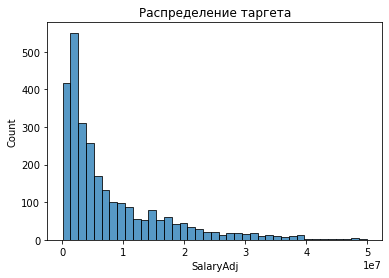

In [55]:
# visualize y_train
sns.histplot(y_train).set_title('Распределение таргета');

🦍 Отобразим тепловую карту фичей

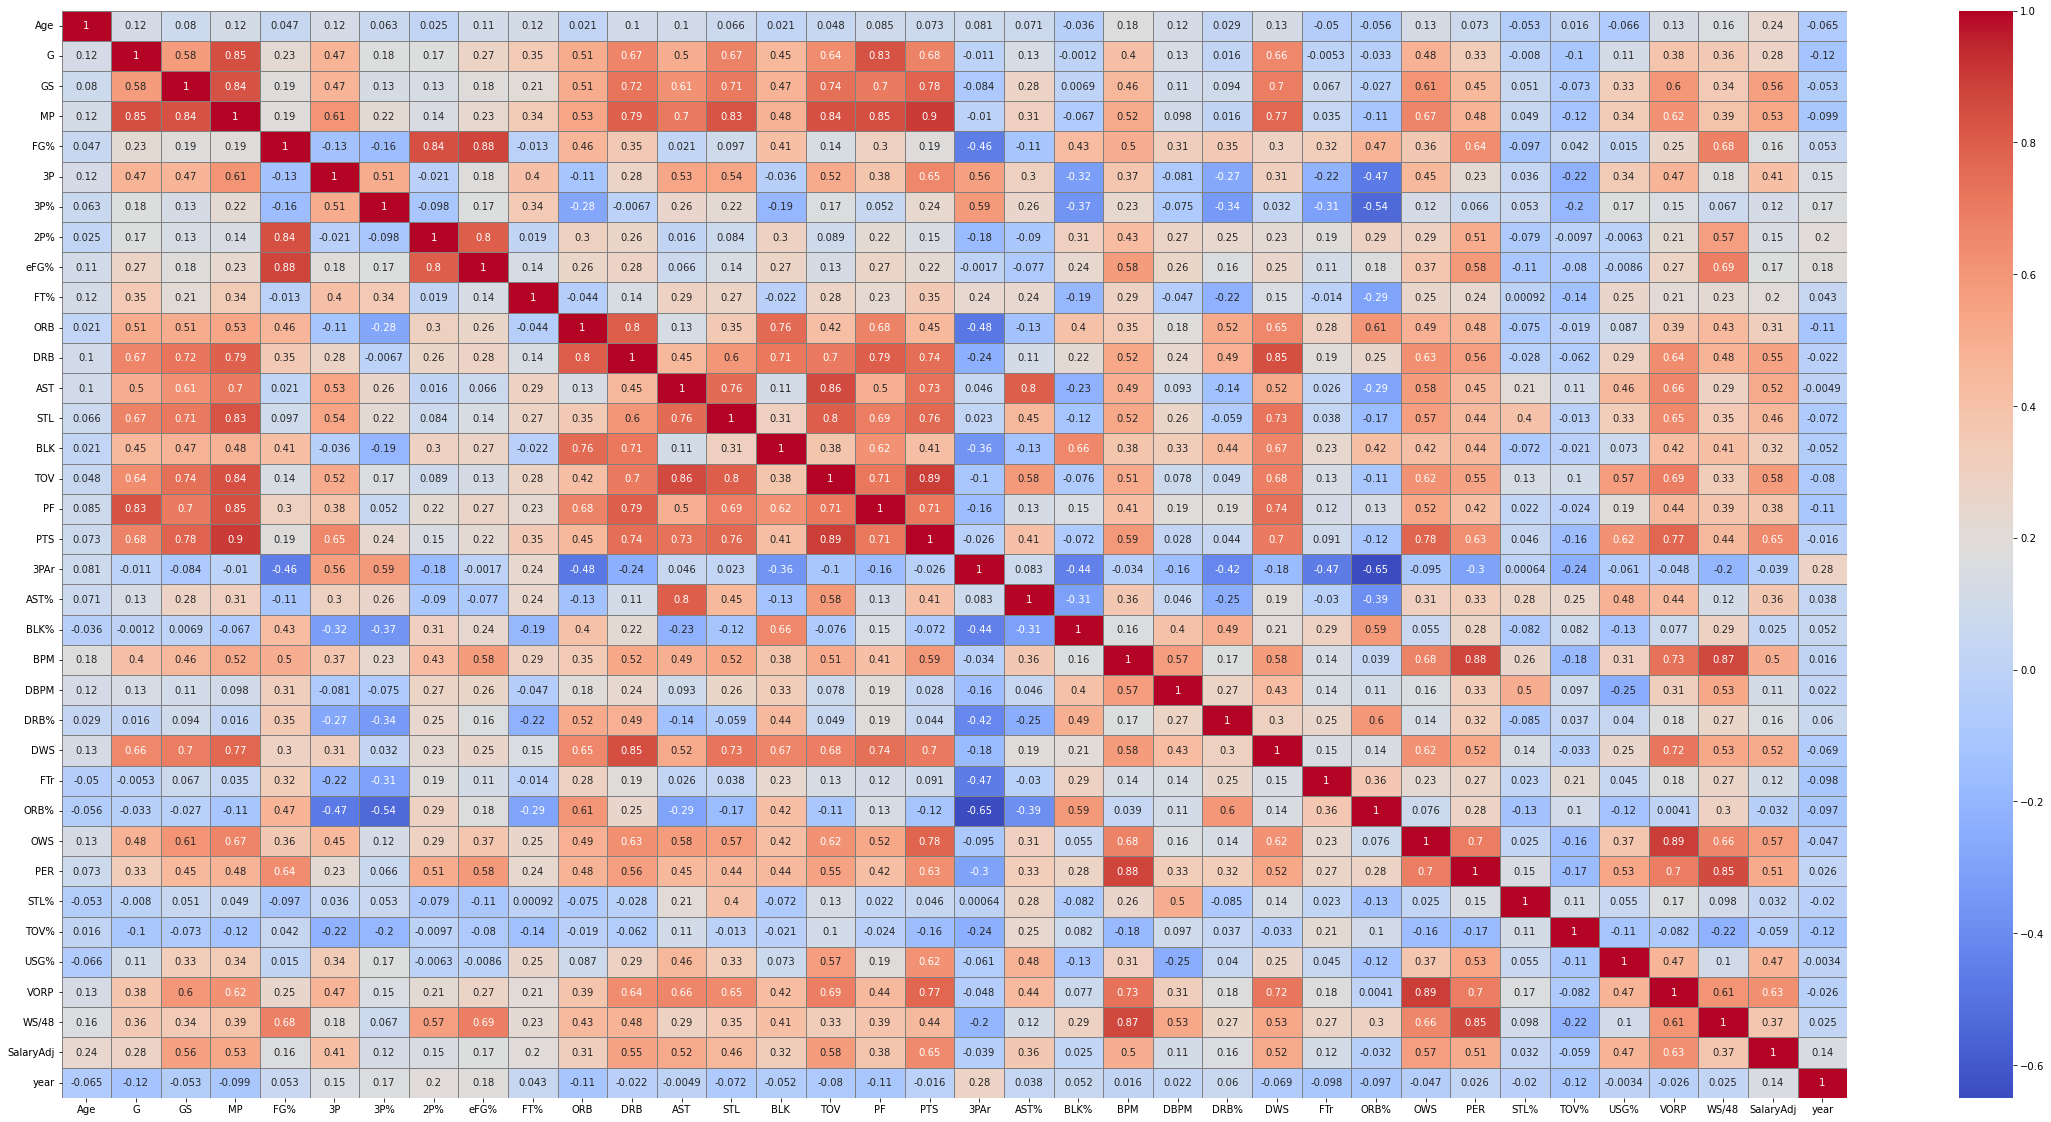

In [12]:
plt.figure(figsize = (40,20))
sns.heatmap(df_train.corr(), annot = True, cmap= 'coolwarm', linewidths=1, linecolor='grey');

🐩 Попробуем модель Random Forest

In [56]:
from sklearn.ensemble import RandomForestRegressor
rand_forest = RandomForestRegressor(random_state=123)
rand_forest.fit(X_train, y_train)

y_predicted_val = rand_forest.predict(X_val)
print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

mse for val data: 24092914196453.383
r2 score for val data: 0.686481053862693


In [57]:
df_train_cat.shape

(3976, 51)

🐈‍ Попробуем подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`

In [16]:
# https://www.kaggle.com/code/funxexcel/p3-random-forest-tuning-randomizedsearchcv/notebook
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from scipy.stats import uniform


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
#[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#uniform(loc=10, scale=80)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
clf = RandomizedSearchCV(rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time= 1.4min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time= 1.3min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time= 1.3min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[C

{'n_estimators': 733,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [ ]:
🦊 Отобразим feature_importances_ лучшего случайного леса

In [17]:
# Extract the feature importances into a dataframe
rf_best =  RandomForestRegressor(n_estimators= 733,
                                  min_samples_split = 2,
                                  min_samples_leaf = 1,
                                  max_features = 'auto',
                                  max_depth = 70,
                                  bootstrap = True,
                                  random_state=123)
rf_best.fit(X_train, y_train);
feature_results_rf_best = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': rf_best.feature_importances_})

feature_results_rf_best = feature_results_rf_best.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_rf_best.head(10)

feature  importance
0     PTS    0.197187
1    VORP    0.172733
2     Age    0.074201
3    year    0.065384
4      GS    0.052967
5    USG%    0.052535
6     BPM    0.033050
7     PER    0.031795
8       G    0.025078
9     DRB    0.012642

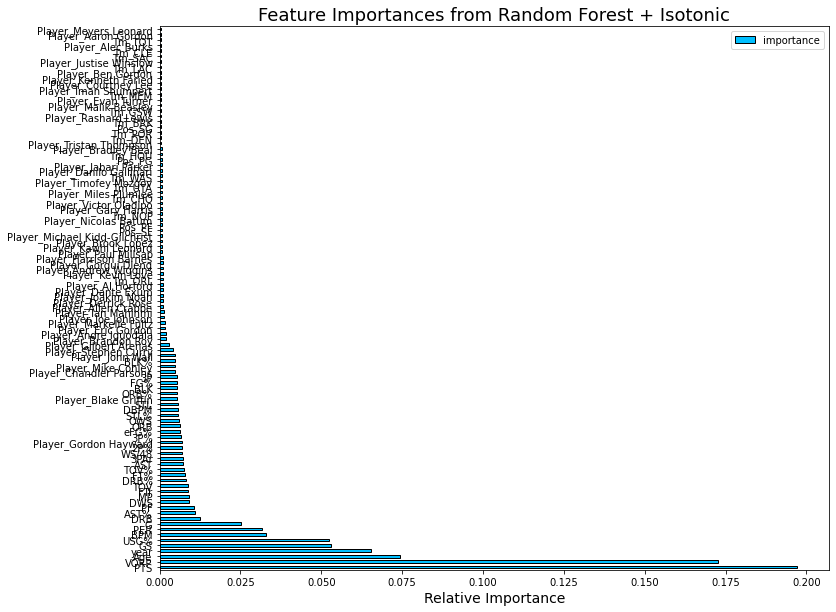

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_rf_best[:100].plot(x = 'feature', y = 'importance',
                             color='deepskyblue',
                             edgecolor = 'k',
                             kind='barh',
                             ax = ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from Random Forest + Isotonic', size = 18);

In [24]:
y_predicted = rf_best.predict(X_val)
print('r2 score for val data:', r2_score(y_val, y_predicted))

r2 score for val data: 0.7016731726799326


(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [81]:
# Extract the names of the most important features
feature_results_rf_best_sorted = feature_results_rf_best.sort_values(by='importance', ascending=False)
most_important_features = feature_results_rf_best_sorted['feature'][:10]

In [78]:
X_val_200 = X_val.sample(200)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
import shap
shap.initjs()
rf_best = RandomForestClassifier(n_estimators= 733,
                                  min_samples_split = 5,
                                  min_samples_leaf = 1,
                                  max_features = 'auto',
                                  max_depth = 90,
                                  bootstrap = False,
                                  random_state=123)
rf_best.fit(X_train.values, y_train.values)
gb_explainer = shap.KernelExplainer(rf_best.predict, X_val_200)
gb_shap_values = gb_explainer.shap_values(X_val_200)

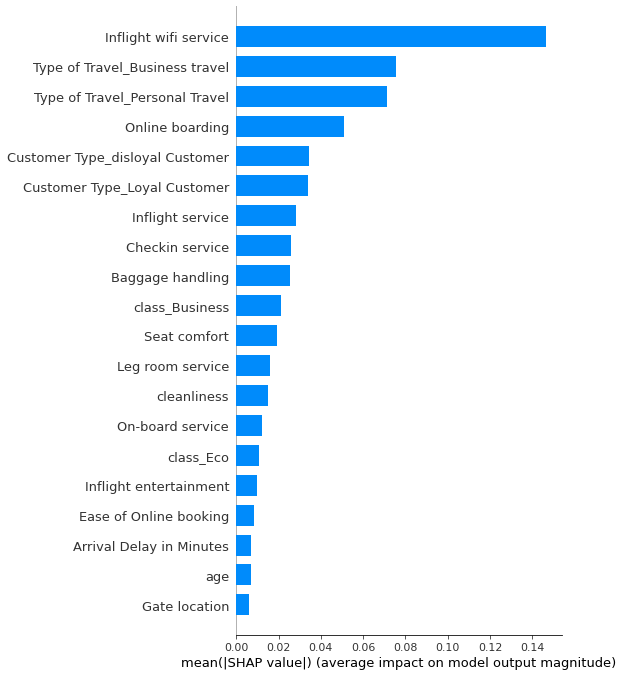

In [79]:
🙈 не смогла запустить на 1000 объектов, на моем ноуте это заняло бы больше 10-ти часов.

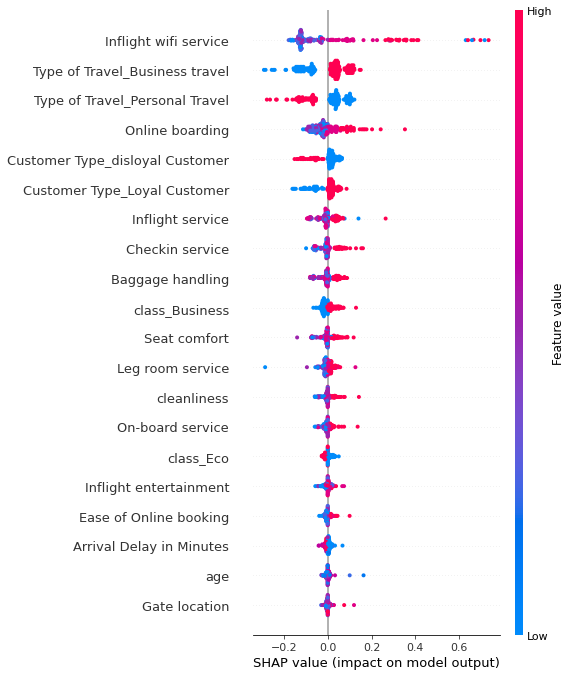

In [80]:
shap.summary_plot(gb_shap_values, X_val_200, plot_type="bar")

In [ ]:
shap.summary_plot(gb_shap_values, X_val_200)

🐺 Интерпретируем важности признаков с помощью LIME

Prediction: 1.0000
Actual Value: 0.0000


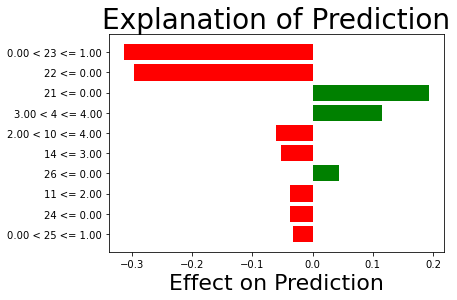

In [83]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train.values,
                                                   mode = 'regression',
                                                   training_labels = y_train.values)

In [85]:
y_pred = rf_best.predict(X_val.values)
# Find the residuals
residuals = abs(y_pred - y_val)
# Exact the worst and best prediction
wrong = X_val.values[np.argmax(residuals), :]
right = X_val.values[np.argmin(residuals), :]
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong,
                                       predict_fn = rf_best.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

Prediction: 1.0000
Actual Value: 1.0000


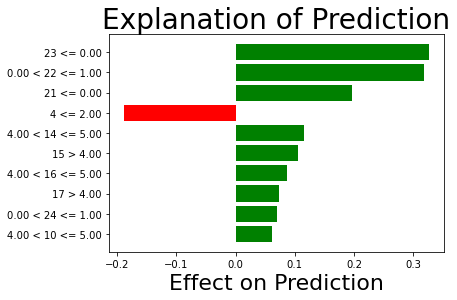

In [86]:
wrong_exp.show_in_notebook(show_predicted_value=False)

In [87]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, rf_best.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
right_exp.show_in_notebook(show_predicted_value=False)

Случайное дерево, дающее лучший скор, сохраняем в pickle

In [180]:
pickle.dump(rf_best, open('RF.pkl', 'wb'))

0.9617759482505146


In [ ]:
with open('RF.pkl', 'rb') as f:
    pickled_model = pickle.load(f)
result = pickled_model.score(X_val, y_val)
print(result)

# Бустинги

## CatBoost

🐅 Пробуем модель CatBoostRegressor

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pipelineLR = Pipeline([
    #('scaler_', MyStandardScaler(continuous_cols)),
    ('features', PolynomialFeatures(degree = 3)),
    ('model_', LinearRegression())
    ])
pipelineLR.fit(X_train, y_train)

y_predicted_val = pipelineLR.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

In [89]:
from sklearn.preprocessing import PolynomialFeatures
pipelineCatBoost = Pipeline([
    #('scaler_', MyStandardScaler(continuous_cols)),
    #('features', PolynomialFeatures(degree = 2)),
    ('model_', CatBoostRegressor())
    ])
pipelineCatBoost.fit(X_train, y_train)

y_predicted_val = pipelineCatBoost.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

Learning rate set to 0.04813
0:	learn: 8627442.9397614	total: 5.99ms	remaining: 5.98s
1:	learn: 8418476.2961268	total: 13.2ms	remaining: 6.57s
2:	learn: 8256557.8125726	total: 19.7ms	remaining: 6.56s
3:	learn: 8079512.3517029	total: 24ms	remaining: 5.98s
4:	learn: 7915300.1748382	total: 28ms	remaining: 5.57s
5:	learn: 7749581.1119132	total: 32.1ms	remaining: 5.32s
6:	learn: 7603523.6894655	total: 35.4ms	remaining: 5.03s
7:	learn: 7451072.2866102	total: 38.1ms	remaining: 4.73s
8:	learn: 7322939.2494007	total: 41ms	remaining: 4.51s
9:	learn: 7193347.1825976	total: 43.8ms	remaining: 4.34s
10:	learn: 7087058.6008802	total: 47.7ms	remaining: 4.29s
11:	learn: 6969332.6092045	total: 51.8ms	remaining: 4.26s
12:	learn: 6850823.2415222	total: 60.5ms	remaining: 4.59s
13:	learn: 6752547.1859745	total: 64.9ms	remaining: 4.57s
14:	learn: 6646767.9254814	total: 67.9ms	remaining: 4.46s
15:	learn: 6554543.6659224	total: 71.3ms	remaining: 4.39s
16:	learn: 6472295.8186230	total: 74.2ms	remaining: 4.29s
1

In [ ]:
🦌 Подбираем гиперпараметры для CatBoostRegressor с помощью оптуны

In [59]:
def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param)
    reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_val)
    score = r2_score(y_val, y_pred)
    return score

In [60]:
from optuna.samplers import TPESampler
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-17 19:21:04,539] A new study created in memory with name: no-name-36627c81-9aca-4326-b5f9-54c079dbfb2f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-03-17 19:21:09,200] Trial 0 finished with value: 0.6245531502640106 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.004078753792468768, 'l2_leaf_reg': 0.016611469120135294, 'colsample_bylevel': 0.0702894437851079, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 3, 'subsample': 0.8464835395364697}. Best is trial 0 with value: 0.6245531502640106.
suggest_loguniform has been deprecated in v3.0.0.

Number of completed trials: 90
Best trial:
	Best Score: 0.7195768826648757
	Best Params: 
    loss_function: RMSE
    learning_rate: 0.05167155953296302
    l2_leaf_reg: 0.03043967426257802
    colsample_bylevel: 0.09491883763784946
    depth: 9
    boosting_type: Ordered
    bootstrap_type: MVS
    min_data_in_leaf: 4
    one_hot_max_size: 12


In [85]:
#Re-fit the model with the best hyperparameters
params = trial.params
model = CatBoostRegressor(**params)
pipelineCatBoost = Pipeline([
    ('model_', model)
    ])
pipelineCatBoost.fit(X_train, y_train)
y_pred = pipelineCatBoost.predict(X_val)

print(r2_score(y_val, y_pred))

TypeError: __init__() got an unexpected keyword argument 'min_child_weight'

In [ ]:
pickle.dump(pipelineCatBoost, open('CatBoost.pkl', 'wb'))

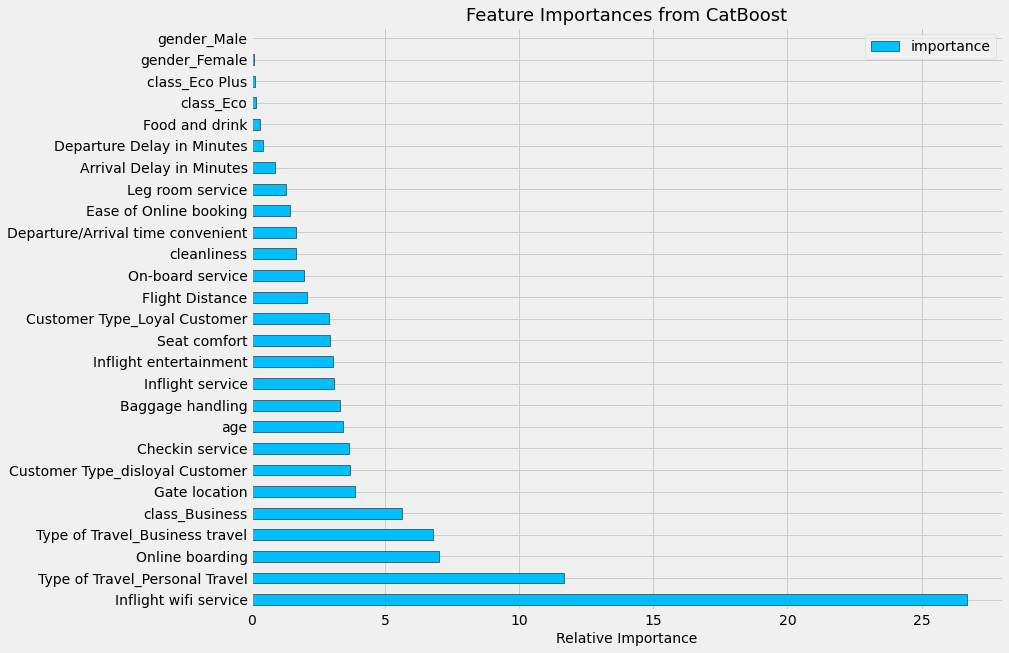

In [ ]:
feature_results_CatBoost = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': pipelineCatBoost[1].feature_importances_})

feature_results_CatBoost = feature_results_CatBoost.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results_CatBoost.head(10)

In [ ]:
# Plot the 15 most important features in a horizontal bar chart
plt.style.use('fivethirtyeight');
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_CatBoost.plot(x = 'feature', y = 'importance',
                              color='deepskyblue',
                              edgecolor = 'k',
                              kind='barh',
                              ax=ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from CatBoost', size = 18);

🐻 Пробуем модель XGBoost

In [62]:
pipelineXGBoost = Pipeline([
    ('model_', XGBRegressor())
    ])
pipelineXGBoost.fit(X_train, y_train)

y_predicted_val = pipelineXGBoost.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

mse for val data: 25375097216162.75
r2 score for val data: 0.6697961204496314


🦌 Подбираем гиперпараметры для XGBoostRegressor с помощью оптуны

In [63]:
# https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    pipelineXGBoost_optuna = Pipeline([
    #('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', XGBRegressor(**params))
    ])

    # Fit the model
    pipelineXGBoost_optuna.fit(X_train, y_train)

    # Make predictions
    y_predicted_val = pipelineXGBoost_optuna.predict(X_val)

    # Evaluate predictions
    accuracy = r2_score(y_val, y_predicted_val)
    return accuracy

In [64]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-03-17 19:35:07,785] A new study created in memory with name: no-name-564d61c2-8b4b-47af-8fc0-9810e353a171
[I 2023-03-17 19:35:08,039] Trial 0 finished with value: 0.6544759292641622 and parameters: {'max_depth': 4, 'learning_rate': 0.09961403524176364, 'n_estimators': 246, 'min_child_weight': 8, 'gamma': 6.954564446754046e-05, 'subsample': 0.11039479108544302, 'colsample_bytree': 0.2764586374904243, 'reg_alpha': 0.2975464781666725, 'reg_lambda': 0.00018873026377876827}. Best is trial 0 with value: 0.6544759292641622.
[I 2023-03-17 19:35:08,152] Trial 1 finished with value: -4.794582405275285 and parameters: {'max_depth': 7, 'learning_rate': 0.2362731991008908, 'n_estimators': 131, 'min_child_weight': 2, 'gamma': 0.14506471504056676, 'subsample': 0.024054108162018594, 'colsample_bytree': 0.05284743639178289, 'reg_alpha': 3.696501455081895e-05, 'reg_lambda': 0.022050190483249098}. Best is trial 0 with value: 0.6544759292641622.
[I 2023-03-17 19:35:08,243] Trial 2 finished with va

CPU times: user 16min 29s, sys: 3.3 s, total: 16min 32s
Wall time: 4min 8s


In [65]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.7185998812399672
  Params: 
    max_depth: 9
    learning_rate: 0.01598190073631623
    n_estimators: 499
    min_child_weight: 10
    gamma: 0.0011493596883366717
    subsample: 0.7305964021319278
    colsample_bytree: 0.7423057639464294
    reg_alpha: 0.01022925293173742
    reg_lambda: 7.072944332049591e-07


In [81]:
#Re-fit the model with the best hyperparameters
params = trial.params
model = XGBRegressor(**params)
pipelineXGBoost = Pipeline([
    #('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', model)
    ])
pipelineXGBoost.fit(X_train, y_train)
y_pred = pipelineXGBoost.predict(X_val)

print(r2_score(y_val, y_pred))

0.7185998812399672


In [76]:
pickle.dump(pipelineXGBoost, open('XGBoost.pkl', 'wb'))

In [78]:
with open('XGBoost.pkl', 'rb') as f:
    pipelineXGBoost = pickle.load(f)

In [83]:
feature_results_XGBoost = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': pipelineXGBoost[0].feature_importances_})
feature_results_XGBoost = feature_results_XGBoost.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_XGBoost.head(10)

feature  importance
0    VORP    0.228531
1     PTS    0.148829
2      GS    0.058513
3    year    0.044909
4     Age    0.041204
5     PER    0.032803
6     BPM    0.032597
7    USG%    0.029654
8       G    0.025071
9     DWS    0.016188

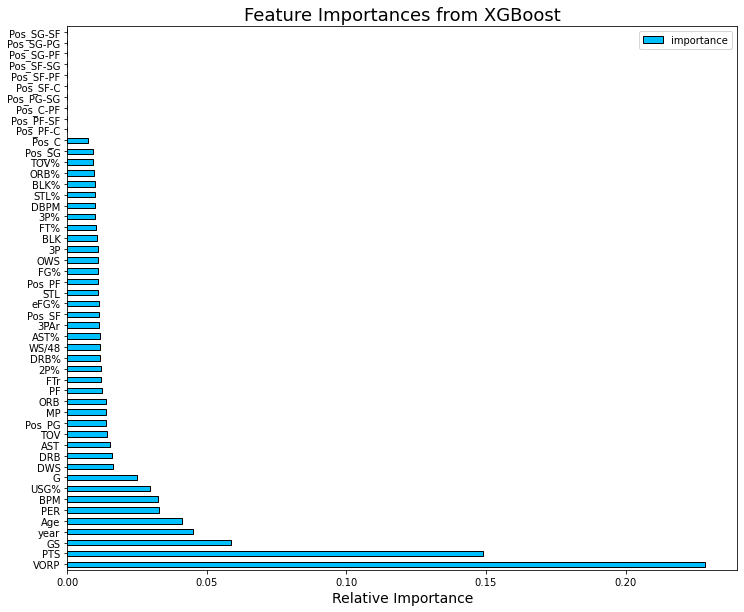

In [84]:
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_XGBoost.plot(x = 'feature', y = 'importance',
                             color='deepskyblue',
                             edgecolor = 'k',
                             kind='barh',
                             ax=ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from XGBoost', size = 18);

# Стекинг

🐧Пробуем стекинг XGBoost + LinearRegression

In [73]:
with open('XGBoost.pkl', 'rb') as f:
    xgboost_pipeline = pickle.load(f)

In [74]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
estimators = [
    ('xgboost', xgboost_pipeline)
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

In [75]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(r2_score(y_val, y_pred))

0.7022716588502189


In [72]:
pickle.dump(clf, open('XGBoost-LR.pkl', 'wb'))

<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

In [ ]:
from matplotlib.gridspec import GridSpec


clf_list = [
    (clf, "XGBoostLR")
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [82]:
with open('CatBoost.pkl', 'rb') as f:
    pipelineCatBoost = pickle.load(f)
with open('RF.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('XGBoost.pkl', 'rb') as f:
    pipelineXGBoost = pickle.load(f)

In [93]:
feature_results_XGBoost = pd.DataFrame({'feature': list(X_train.columns),
                                        'importance': pipelineXGBoost[1].feature_importances_,
                                        'model': 'xgboost'})
feature_results_CatBoost = pd.DataFrame({'feature': list(X_train.columns),
                                         'importance': pipelineCatBoost[1].feature_importances_* 0.01,
                                         'model': 'catboost'})
feature_results_dt = pd.DataFrame({'feature': list(X_train.columns),
                                   'importance': dt.feature_importances_,
                                   'model': 'dt'})
feature_results_rf = pd.DataFrame({'feature': list(X_train.columns),
                                   'importance': rf.feature_importances_,
                                   'model': 'rf'})

index                         feature  importance    model
25     25                       class_Eco    0.045715       rf
50     23  Type of Travel_Personal Travel    0.005558       dt
88      7                   Gate location    0.009524  xgboost
38     11          Inflight entertainment    0.048315       dt
40     13                Leg room service    0.007233       dt

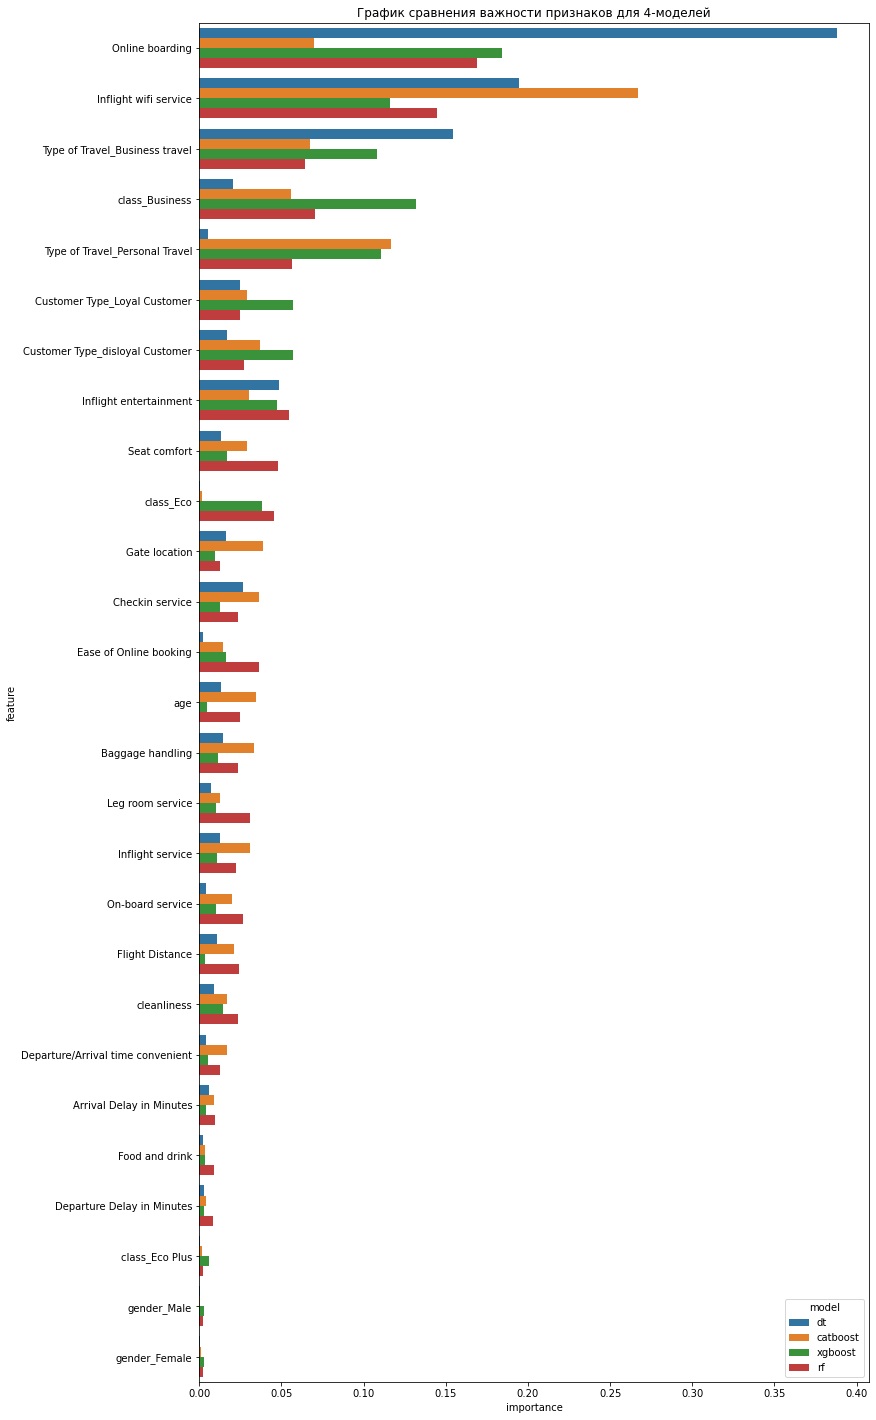

In [94]:
feature_results_full = pd.concat([feature_results_rf,
                                  feature_results_dt,
                                  feature_results_CatBoost,
                                  feature_results_XGBoost
                                 ]).reset_index()
feature_results_full = feature_results_full.sort_values(by='importance', ascending=False)
feature_results_full.sample(5)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
sns.barplot(data = feature_results_full,
            y = 'feature',
            x = 'importance',
            hue = 'model',
            ax = ax).set_title('График сравнения важности признаков для 3-моделей');

(0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif`

In [118]:
selector = SelectKBest(chi2, k=20)
selector.fit(X_train, y_train)
selected_feature_names = X_train.columns[selector.get_support()]
check_chi = any(item in selected_feature_names for item in removed_features)
print('test for chi2:', check_chi)

test for mutual_info_classif: False


In [ ]:
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(X_train, y_train)
selected_feature_names = X_train.columns[selector.get_support()]
check_mutual_info_classif = any(item in selected_feature_names for item in removed_features)
print('test for mutual_info_classif:', check_mutual_info_classif)

In [ ]:
🐥 Да, оба теста показали, что по графику выбранные вручную 3 признака можно удалить.

(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [93]:
from sklearn.feature_selection import RFECV


estimator = LogisticRegression(penalty = 'l2', max_iter = 1000)
selector = RFECV(estimator, step=1, cv=5, min_features_to_select = 10)
selector = selector.fit(X_train, y_train)
selector.support_

In [15]:
X_train_reduced = X_train.drop(columns = ['class_Eco Plus', 'gender_Male', 'gender_Female', 'Departure Delay in Minutes'])
X_val_reduced = X_val.drop(columns = ['class_Eco Plus', 'gender_Male', 'gender_Female', 'Departure Delay in Minutes'])

Accuracy score before removing 4 features: 0.9620699794178182
Accuracy score after removing 4 features: 0.96141657682381


In [ ]:
rf_default = RandomForestRegressor()
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_val)

print('r2 score before removing 4 features:', r2_score(y_val, y_pred))

rf_default = RandomForestRegressor()
rf_default.fit(X_train_reduced, y_train)
y_pred = rf_default.predict(X_val_reduced)

print('r2 score after removing 4 features:', r2_score(y_val, y_pred))